In [189]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, MultiPoint
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.offline as off
from sklearn.cluster import KMeans

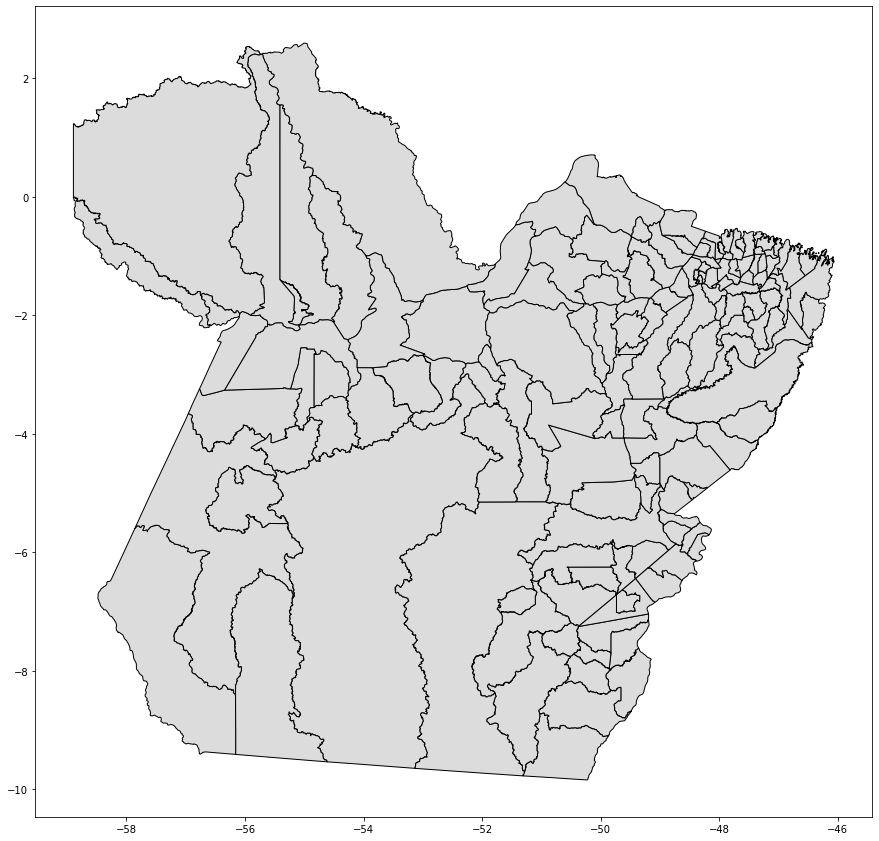

In [190]:
state = gpd.read_file('../data/shapes/pa_municipios/15MUE250GC_SIR.shp', encoding='utf-8')
state.plot(color='#dcdcdc', edgecolor='k', figsize=(15, 15))

Text(0.5, 337.4770900948511, 'Longitude (°)')

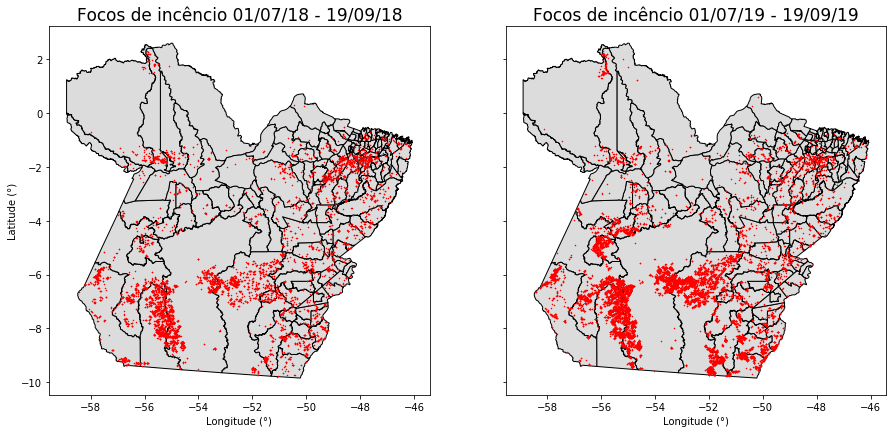

In [191]:
focus2018 = gpd.read_file('../data/focos/Focos.2018-07-01.2018-09-19.shp/')
focus2019 = gpd.read_file('../data/focos/Focos.2019-07-01.2019-09-19.shp/')

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(15,15))
fonttitle = dict(size=17)
state.plot(ax=ax1, color='#dcdcdc', edgecolor='k')
state.plot(ax=ax2, color='#dcdcdc', edgecolor='k')

focus2018.plot(ax=ax1, marker='*', markersize=.4, color='red')
focus2019.plot(ax=ax2, marker='*', markersize=.4, color='red')

ax1.set_title('Focos de incêncio 01/07/18 - 19/09/18', fontdict=fonttitle)
ax2.set_title('Focos de incêncio 01/07/19 - 19/09/19', fontdict=fonttitle)

ax1.set_ylabel('Latitude (°)')
ax1.set_xlabel('Longitude (°)')
ax2.set_xlabel('Longitude (°)')

In [20]:
# d2019 = {}
# for i, row in focus2019.iterrows():
#     x, y = row.Longitud, row.Latitude
#     point = Point(x, y)

#     for i, city in state.iterrows():
#         geom = city['geometry']
#         name = city['NM_MUNICIP']
#         if geom.contains(point):
#             if not d2019.get(name):
#                 d2019[name] = 0
#             d2019[name] += 1
#             break

In [25]:
# def find(l, v):
#     for i, x in enumerate(l):
#         if v == x:
#             return True, i
#     return False, 0

# keys, values = list(d2019.keys()), list(d2019.values())

# focus_det = []

# for i, row in state.iterrows():
#     city_name = row['NM_MUNICIP']
#     found = False
#     contains, index = 0, 0
#     for key in keys:
#         contains, index = find(keys, city_name)
#         if contains:
#             found = True
#             break
#     if found:    
#         focus_det.append(values[index])
#     else:
#         focus_det.append(0)
        
# state['foco_2019'] = focus_det
# state.to_file('../data/shapes/state_with_focus/focus2019.shp', encoding = 'utf-8')

In [200]:
c_shape = gpd.read_file('../data/shapes/state_with_focus/focus2019.shp', encoding='utf-8') 
c_shape.head()

,NM_MUNICIP,CD_GEOCMU,foco,foco_2019,geometry
0,ALENQUER,1500404,49,35,POLYGON ((-54.86211511799996 0.372521589012336...
1,ALMEIRIM,1500503,2,12,POLYGON ((-54.87225092899999 2.433746586080204...
2,ALTAMIRA,1500602,1243,3267,POLYGON ((-51.95812355600002 -3.47704330411428...
3,AVEIRO,1501006,28,88,POLYGON ((-55.23386972699995 -3.24192074610664...
4,BELTERRA,1501451,5,21,POLYGON ((-54.83244893099985 -2.66109809308753...


In [201]:
group = c_shape.groupby(['NM_MUNICIP']).agg({'foco': ['sum'], 'foco_2019': ['sum']})
group.head()

,foco,foco_2019
,sum,sum
NM_MUNICIP,,
ABAETETUBA,42,24
ABEL FIGUEIREDO,17,10
ACARÁ,121,87
AFUÁ,0,0
ALENQUER,49,35


In [202]:
c_shape.max()

NM_MUNICIP     ÓBIDOS
CD_GEOCMU     1508407
foco             1243
foco_2019        3267
dtype: object

In [203]:
cities = list(group.index)
values2018 = list(group['foco']['sum'].values)
values2019 = list(group['foco_2019']['sum'].values)

In [204]:
fig = go.Figure()

fig.add_trace(
    go.Pie(values=[np.sum(values2018), np.sum(values2019)], 
           marker=dict(colors=['orange', 'blue']), 
           labels=[2018, 2019], name='Focos detectados em 2018')
)

fig.update_layout(
    template='plotly_dark',
    title='Total de focos em cada ano (2018 e 2019)'
)

off.iplot(fig)

In [205]:
fig = go.Figure()

fig.add_trace(
    go.Pie(values=[np.sum(values2018), np.sum(values2019)], 
           marker=dict(colors=['orange', 'blue']), 
           labels=[2018, 2019], name='Focos detectados em 2018')
)


fig.update_layout(
    template='plotly_dark',
    title='Total de focos em cada ano (2018 e 2019)'
)

off.iplot(fig)

In [206]:
fig = go.Figure()

fig.add_trace(
    go.Box(x=values2018, marker=dict(color='orange'),
           name='Focos detectados em 2018')
)

fig.add_trace(
    go.Box(x=values2019, marker=dict(color='blue'), 
           name='Focos detectados em 2019')
)

fig.update_yaxes(showticklabels=False)


fig.update_layout(
    template='plotly_dark',
    title='Focos de incêndio em 2018 e 2019'
)

off.iplot(fig)

number of estimated clusters : 20


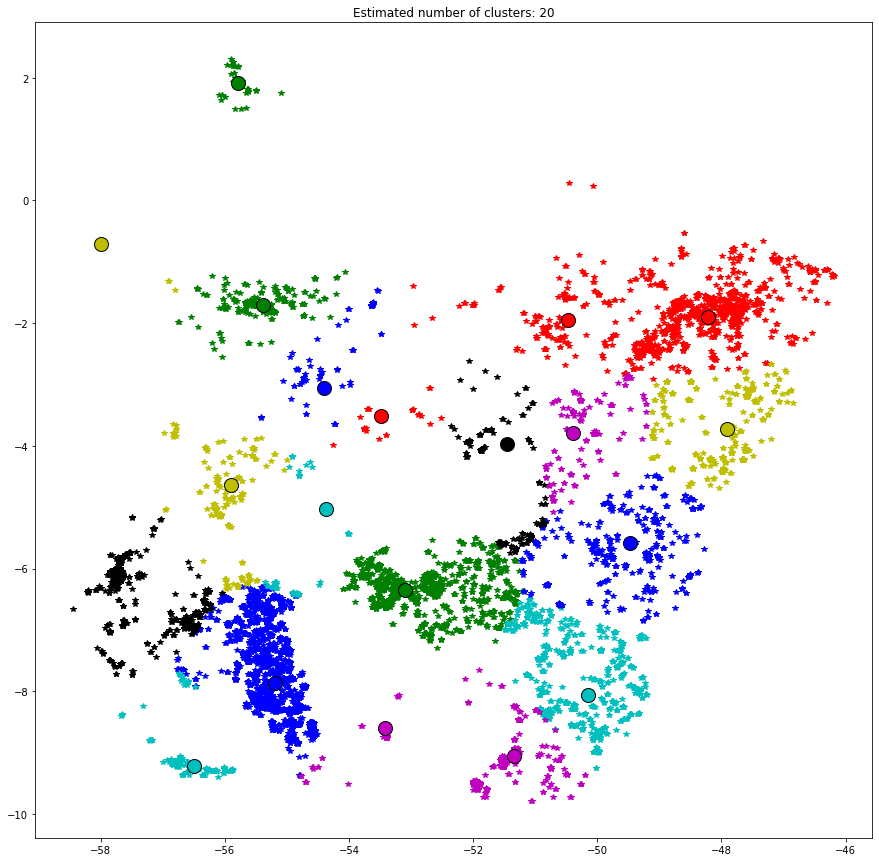

In [207]:
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets.samples_generator import make_blobs

lat2018 = focus2018.Latitude.values
lon2018 = focus2018.Longitud.values

values = pd.DataFrame({'lon': lon2018, 'lat': lat2018}).values
bandwidth = estimate_bandwidth(values, quantile=0.051, 
                               n_samples=None, random_state=0)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(values)

labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

X = values
import matplotlib.pyplot as plt
from itertools import cycle

plt.figure(figsize=(15, 15))
plt.clf()


colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + '*')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [209]:
focus2018

,DataHora,Satelite,Pais,Estado,Municipi,Bioma,DiaSemCh,Precipit,RiscoFog,Latitude,Longitud,AreaIndu,FRP,geometry
0,2018/07/01 16:35:00,AQUA_M-T,Brasil,PARA,SAO JOAO DA PONTA,Amazonia,2,2.18,0.01,-0.901,-47.988,None,7.0,POINT (-47.988 -0.901)
1,2018/07/01 16:35:00,AQUA_M-T,Brasil,PARA,CAPANEMA,Amazonia,0,2.98,0.03,-1.097,-47.014,None,15.2,POINT (-47.014 -1.097)
2,2018/07/01 16:35:00,AQUA_M-T,Brasil,PARA,SAO MIGUEL DO GUAMA,Amazonia,5,0.20,0.08,-1.542,-47.609,None,10.7,POINT (-47.609 -1.542)
3,2018/07/01 16:35:00,AQUA_M-T,Brasil,PARA,SAO MIGUEL DO GUAMA,Amazonia,5,0.20,0.08,-1.543,-47.619,None,15.3,POINT (-47.619 -1.543)
4,2018/07/01 16:35:00,AQUA_M-T,Brasil,PARA,IRITUIA,Amazonia,11,0.00,0.09,-1.871,-47.407,None,6.8,POINT (-47.407 -1.871)
5,2018/07/01 16:35:00,AQUA_M-T,Brasil,PARA,SAO DOMINGOS DO CAPIM,Amazonia,5,3.30,0.04,-1.918,-47.809,None,28.0,POINT (-47.809 -1.918)
6,2018/07/01 16:35:00,AQUA_M-T,Brasil,PARA,SAO DOMINGOS DO CAPIM,Amazonia,5,3.30,0.04,-1.928,-47.808,None,34.0,POINT (-47.808 -1.928)
7,2018/07/01 16:35:00,AQUA_M-T,Brasil,PARA,ACARA,Amazonia,11,0.00,0.11,-1.937,-48.369,None,33.9,POINT (-48.369 -1.937)
8,2018/07/01 16:35:00,AQUA_M-T,Brasil,PARA,ACARA,Amazonia,11,0.00,0.11,-1.939,-48.381,None,15.8,POINT (-48.381 -1.939)
9,2018/07/01 16:35:00,AQUA_M-T,Brasil,PARA,TOME-ACU,Amazonia,10,0.05,0.09,-2.205,-48.112,None,13.2,POINT (-48.112 -2.205)
